In [1]:
!nvidia-smi

Tue May 28 11:42:20 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    18W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!ls

sample_data


In [3]:
!pip install PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#https://drive.google.com/open?id=1kk0ytV9j_UEZWEDSubJN8ws-vwWh6TER

download = drive.CreateFile({'id': '1kk0ytV9j_UEZWEDSubJN8ws-vwWh6TER'})
download.GetContentFile('flower_data.zip')

#https://drive.google.com/open?id=1wPFrVNDbW6Th5bzMR-ySjlHDHtyxVkLO

download = drive.CreateFile({'id': '1wPFrVNDbW6Th5bzMR-ySjlHDHtyxVkLO'})
download.GetContentFile('flower_data_original_test.zip')

#https://drive.google.com/open?id=1sMSp2kYwoLAJ1S7zNAL-0W1ihYsvmBUd
download = drive.CreateFile({'id': '1sMSp2kYwoLAJ1S7zNAL-0W1ihYsvmBUd'})
download.GetContentFile('cat_to_name.json')


     |████████████████████████████████| 993kB 9.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [4]:
!ls

adc.json	  flower_data_original_test.zip  sample_data
cat_to_name.json  flower_data.zip


In [9]:
!ls -r flower_data_test

99  93	88  82	77  71	66  60	55  5	44  39	33  28	22  17	11
98  92	87  81	76  70	65  6	54  49	43  38	32  27	21  16	102
97  91	86  80	75  7	64  59	53  48	42  37	31  26	20  15	101
96  90	85  8	74  69	63  58	52  47	41  36	30  25	2   14	100
95  9	84  79	73  68	62  57	51  46	40  35	3   24	19  13	10
94  89	83  78	72  67	61  56	50  45	4   34	29  23	18  12	1


In [0]:
!unzip flower_data.zip

In [0]:
!mkdir flower_data_test

In [0]:
!unzip flower_data_original_test.zip -d flower_data_test

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import io
import zipfile
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [0]:
#uploadId = '1w26x8ZtouNfb2X9piy6cEqsgi83BNpCN'
#uploaded = drive.CreateFile({'parents':[{'id': uploadId}] , 'title' : 'flower_data.zip'})
#uploaded.SetContentFile('flower_data.zip')
#uploaded.Upload()

# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [0]:
# Imports here
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch
from torchvision import datasets,transforms,utils,models
import matplotlib.pyplot as plt
import os
import time
import copy

In [12]:
!ls -r flower_data/

valid  train


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [13]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

datadict={
    'train':train_dir,
    'valid':valid_dir
}
datadict['train']

'flower_data/train'

In [0]:
# TODO: Define your transforms for the training and validation sets
batch_size=16

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
    'valid':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
}

# TODO: Load the datasets with ImageFolder
image_datasets = {i:datasets.ImageFolder(datadict[i],data_transforms[i]) for i in ['train','valid']}

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {i:torch.utils.data.DataLoader(image_datasets[i],batch_size=batch_size,shuffle=True) for i in ['train','valid']}

dataset_sizes={i:len(image_datasets[i]) for i in ['train','valid']}

class_names=image_datasets['train'].classes

In [15]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fcbfd2e3a20>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x7fcbfd257390>}

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [0]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [17]:
cat_to_name

{'1': 'pink primrose',
 '10': 'globe thistle',
 '100': 'blanket flower',
 '101': 'trumpet creeper',
 '102': 'blackberry lily',
 '11': 'snapdragon',
 '12': "colt's foot",
 '13': 'king protea',
 '14': 'spear thistle',
 '15': 'yellow iris',
 '16': 'globe-flower',
 '17': 'purple coneflower',
 '18': 'peruvian lily',
 '19': 'balloon flower',
 '2': 'hard-leaved pocket orchid',
 '20': 'giant white arum lily',
 '21': 'fire lily',
 '22': 'pincushion flower',
 '23': 'fritillary',
 '24': 'red ginger',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '27': 'prince of wales feathers',
 '28': 'stemless gentian',
 '29': 'artichoke',
 '3': 'canterbury bells',
 '30': 'sweet william',
 '31': 'carnation',
 '32': 'garden phlox',
 '33': 'love in the mist',
 '34': 'mexican aster',
 '35': 'alpine sea holly',
 '36': 'ruby-lipped cattleya',
 '37': 'cape flower',
 '38': 'great masterwort',
 '39': 'siam tulip',
 '4': 'sweet pea',
 '40': 'lenten rose',
 '41': 'barbeton daisy',
 '42': 'daffodil',
 '43': 'sword lily',

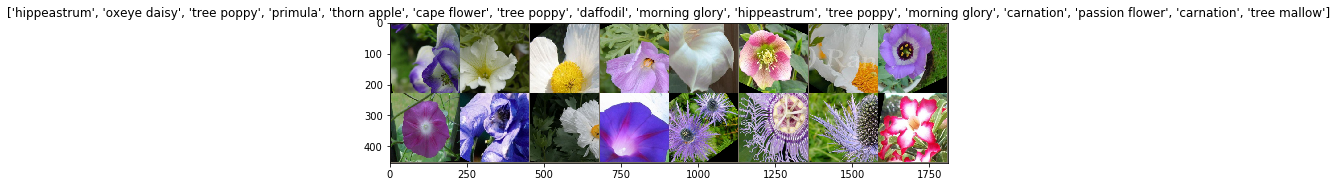

In [18]:
fig,ax=plt.subplots(figsize=(10,10))

def imshow(inp,title=None):
    inp=inp.numpy().transpose((1,2,0))
    mean=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])    
    
    inp=std*inp+mean
    inp=np.clip(inp,0,1)
    ax.imshow(inp)
    
    if title is not None:
        plt.title(title)
    plt.pause(0.1)
    
inputs,classes=next(iter(dataloaders['train']))
out=utils.make_grid(inputs)

imshow(out,title=[cat_to_name[str(i.item())] for i in classes])

In [19]:
for x in classes:
    print(x.item(), cat_to_name[str(x.item())])

91 hippeastrum
49 oxeye daisy
70 tree poppy
53 primula
75 thorn apple
37 cape flower
70 tree poppy
42 daffodil
76 morning glory
91 hippeastrum
70 tree poppy
76 morning glory
31 carnation
77 passion flower
31 carnation
86 tree mallow


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [28]:
# TODO: Build and train your network

#model=models.vgg19(pretrained=True)

#for param in model.parameters():
#    param.requires_grad=False
    
MY_model=models.resnet152(pretrained=True)

for param in MY_model.parameters():
        param.requires_grad=False
    
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)
print(MY_model)

cuda
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), b

In [0]:
# TODO: Save the checkpoint 
classifier2=nn.Linear(2048,102)

MY_model.fc=classifier2
loss_fn=nn.CrossEntropyLoss()
#loss_fn=nn.NLLLoss()
optimizer=optim.Adam(MY_model.fc.parameters(),lr=0.001)
scheduler=optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma=0.1)


In [0]:
def train_model(model,criterion,optimizer,scheduler,epochs=25,device='cuda'):
    start=time.time()
    best_model=copy.deepcopy(model.state_dict())
    best_acc=0.0
    
    for e in range(epochs):
        print('epoch {}/{}'.format(e,epochs-1))
        print('-'*10)
        
        for mode in ['train','valid']:
            if mode=='train':
                scheduler.step()
                model.train()
            else:
                model.eval()
            
            running_loss=0.0
            running_corrects=0
            
            for inputs,labels in dataloaders[mode]:
                #inputs.to(device)
                #labels.to(device)
                inputs.cuda()
                labels.cuda()
                
                #print(device,type(inputs),type(labels),type(model),type(best_model))
                #
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(mode=='train'):
                    
                    outputs=model(inputs.cuda())
                    #outputs.cuda()
                    pred_values,preds=torch.max(outputs,1)#retunrs values, indexes
                    loss=criterion(outputs.cuda(),labels.cuda())
                    
                    if mode=='train':
                        loss.backward()
                        optimizer.step()
                    
                running_loss+=loss.item()*inputs.size(0)
                running_corrects+=torch.sum(preds.cuda()==labels.data.cuda())
                
            epoch_loss=running_loss/dataset_sizes[mode]
            epoch_acc=running_corrects.double()/dataset_sizes[mode]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(mode,epoch_loss,epoch_acc))
            
            if (mode=='valid' and epoch_acc>best_acc):
                best_acc=epoch_acc
                best_model=copy.deepcopy(model.state_dict())
                
                print('----saving the model----')
                
                model.cpu()
                
                save_checkpoint('checkpoint.pth',model,optimizer,best_acc,e)
                model.cuda()
                
                #best_model.cuda()
        
        print()
    
    time_taken=time.time()-start
    
    print('Training complete in {:.0f}m {:.0f}s'.format(time_taken//60,time_taken%60))
    print('Best Validation Acc: {:.4f}'.format(best_acc))
    
    model.load_state_dict(best_model)
    return model
            
                
                
    

In [31]:
MY_model.to(device)
model_final=train_model(MY_model,loss_fn,optimizer,scheduler,15,device)

epoch 0/14
----------
train Loss: 2.2974 Acc: 0.5121
valid Loss: 0.6226 Acc: 0.8667
----saving the model----
epochs 0 	 best accuracy 0.8667
!-!-checkpoint saved-!-!

epoch 1/14
----------
train Loss: 0.9337 Acc: 0.7674
valid Loss: 0.4170 Acc: 0.8973
----saving the model----
epochs 1 	 best accuracy 0.8973
!-!-checkpoint saved-!-!

epoch 2/14
----------
train Loss: 0.7157 Acc: 0.8106
valid Loss: 0.3723 Acc: 0.8936

epoch 3/14
----------
train Loss: 0.6222 Acc: 0.8349
valid Loss: 0.3322 Acc: 0.9071
----saving the model----
epochs 3 	 best accuracy 0.9071
!-!-checkpoint saved-!-!

epoch 4/14
----------
train Loss: 0.4452 Acc: 0.8880
valid Loss: 0.2097 Acc: 0.9499
----saving the model----
epochs 4 	 best accuracy 0.9499
!-!-checkpoint saved-!-!

epoch 5/14
----------
train Loss: 0.4197 Acc: 0.8933
valid Loss: 0.2143 Acc: 0.9511
----saving the model----
epochs 5 	 best accuracy 0.9511
!-!-checkpoint saved-!-!

epoch 6/14
----------
train Loss: 0.4260 Acc: 0.8916
valid Loss: 0.1983 Acc: 0.9

In [32]:
device

device(type='cuda')

In [33]:
!ls

adc.json	  flower_data			 flower_data.zip
cat_to_name.json  flower_data_original_test.zip  sample_data
checkpoint.pth	  flower_data_test


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:
def save_checkpoint(path,model,optimizer,best_acc,epochs):
    model.class_to_idx=image_datasets['train'].class_to_idx
    
    torch.save({
        
        'arch':'resnet152',
        'num_epochs':epochs,
        'best_acc':best_acc,
        'model_state_dict':model.state_dict(),
        'optim_state_dict':optimizer.state_dict(),
        'class_to_idx':model.class_to_idx
        
    },path)
    
    print('epochs {} \t best accuracy {:.4f}'.format(epochs,best_acc))
    print('!-!-checkpoint saved-!-!')
    

In [26]:
save_checkpoint('checkpoint.pth',MY_model,optimizer,92,10)

epochs 10 	 best accuracy 92.0000
!-!-checkpoint saved-!-!


In [0]:
!ls

adc.json	  flower_data			 flower_data.zip
cat_to_name.json  flower_data_original_test.zip  sample_data
checkpoint.pth	  flower_data_test


# testing

In [0]:
testdir='flower_data_test'
test_data_transform=transforms.Compose([
    
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])

])

image_test_datasets=datasets.ImageFolder(testdir,test_data_transform)

batch_size=16

test_dataloaders=torch.utils.data.DataLoader(image_test_datasets,batch_size=batch_size,shuffle=True)

test_dataset_size=len(image_test_datasets)


In [0]:
def calc_test_acc(model):
    model.eval()
    model.cuda()
    running_corrects=0
    
    with torch.no_grad():
        for inputs,labels in test_dataloaders:
            #inputs,labels = inputs.cuda(),labels=labels.cuda()
            inputs=inputs.cuda()
            labels=labels.cuda()
            outputs=model.forward(inputs)
            predvalues,preds=torch.max(outputs,1)
            running_corrects+=torch.sum(labels.data==preds)
        
    acc=running_corrects.double()/test_dataset_size
        
    print('test accuracy',acc)

In [38]:
calc_test_acc(MY_model)

test accuracy tensor(0.9316, device='cuda:0', dtype=torch.float64)


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [43]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(path,model,optimizer):
    print(path)
    checkpoint=torch.load(path)
    
    print('epochs {}\n best accuracy {}'.format(checkpoint['num_epochs'],checkpoint['best_acc']))
    
    if checkpoint['arch']=='resnet152':
        model=models.resnet152(pretrained=True)
        
        for param in model.parameters():
            param.requires_grad=False
            
    else:
        print('arch error')
        return None
    
    model.class_to_idx=checkpoint['class_to_idx']
    
    classifier=nn.Linear(2048,102)
    model.fc=classifier
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model

MY_model_2=load_checkpoint('checkpoint.pth',MY_model,optimizer)

print(MY_model_2)

checkpoint.pth
epochs 9
 best accuracy 0.9559902200488998
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0):

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [45]:
ll=os.listdir()
ll

['.config',
 'flower_data_test',
 'cat_to_name.json',
 'adc.json',
 'flower_data_original_test.zip',
 'checkpoint.pth',
 'flower_data.zip',
 'flower_data',
 'sample_data']

In [0]:
uploadId = '1w26x8ZtouNfb2X9piy6cEqsgi83BNpCN'
uploaded = drive.CreateFile({'parents':[{'id': uploadId}] , 'title' : 'checkpoint.pth'})
uploaded.SetContentFile('checkpoint.pth')
uploaded.Upload()

In [0]:
from PIL import Image

In [0]:
if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    pil_img=Image.open(image_path)
    
    loader=transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
    
    
    pil_img=loader(pil_img).float()
    np_img=np.array(pil_img)/225
    
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    
    np_img=(np.transpose(np_img,(1,2,0))-mean)/std
    #np_img=(np_img-mean)/std
    
    
    np_img=np.transpose(np_img,(2,0,1))
    
    return np_img
    

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imshow(image, ax=None, title='Flower'):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = np.transpose(image,(1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    image=image*255.0
    
    image=np.array(image,dtype=float)
    ax.imshow(image)
    
    return ax

ValueError: ignored

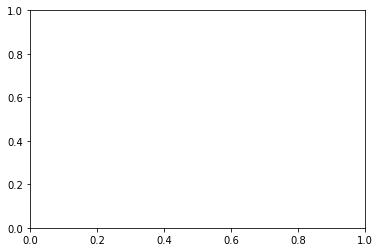

In [102]:
image_path='flower_data/valid/28/image_05258.jpg'
ims=imshow(process_image(image_path))
plt.imshow(ims)
#plt.imshow(ims, clim=(0.064, 0.068))
#mod_img = ndimage.median_filter(ims, 20)
#plt.imshow(mod_img)

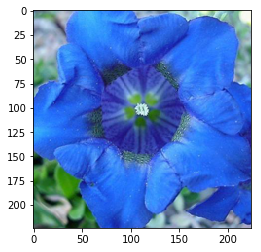

In [105]:
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    #from PIL import Image
    img = Image.open(image_path)
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img

def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

image_path = 'flower_data/valid/28/image_05258.jpg'
img = process_image(image_path)
imshow(img)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
def predict(image_path, model, num_k=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    model.eval()
    
    model.cpu()
    
    np_img=process_image(image_path)
    img_tensor=torch.from_numpy(np_img).type(torch.FloatTensor)
    img_tensor=torch.unsqueeze(img_tensor,0)
    probs=torch.exp(model.forward(img_tensor))
    
    top_probs,top_labs=probs.topk(num_k)
    
    top_probs=top_probs.detach().numpy().tolist()[0]
    top_labs=top_labs.detach().numpy().tolist()[0]
    
    
    idx_to_class={val:key for key,val in model.class_to_idx.items()}
    
    top_labels=[idx_to_class[lab] for lab in top_labs]
    
    top_flowers=[cat_to_name[idx_to_class[lab]] for lab in top_labs]
    
    return top_probs,top_labels,top_flowers
    

In [113]:
probs,classes,flowers=predict(image_path,MY_model_2)
print(probs)
print(classes)
print(flowers)

[2.3770978450775146, 0.0017433331813663244, 0.00016231260087806731, 0.00015321557293646038, 7.420249312417582e-05]
['28', '3', '43', '98', '68']
['stemless gentian', 'canterbury bells', 'sword lily', 'mexican petunia', 'bearded iris']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [0]:
# TODO: Display an image along with the top 5 classes
def plot_solution(img_path):
    fig,(ax1,ax2)=plt.subplots(1,2)
    fig.figsize=(15,15)
    ims=imshow(process_image(img_path),ax2)
    probs,classes,flowers=predict(img_path,MY_model_2)
    ax1.barh(flowers,probs)
    plt.show()

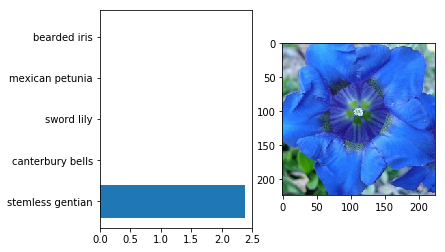

In [132]:
plot_solution(image_path)

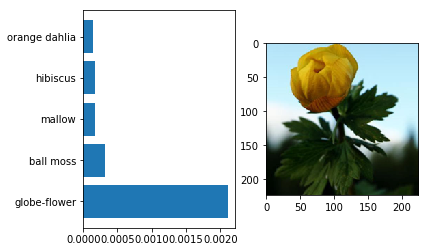

In [133]:
plot_solution('flower_data_test/16/image_06670.jpg')

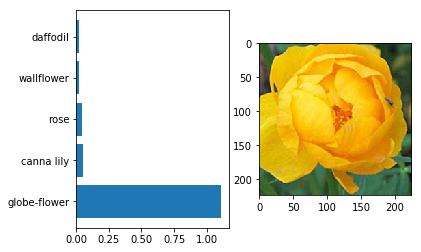

In [134]:
plot_solution('flower_data_test/16/image_06657.jpg')

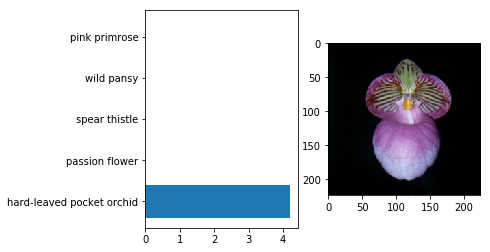

In [135]:
plot_solution('flower_data_test/2/image_05100.jpg')

In [136]:
!ls

adc.json	  flower_data			 flower_data.zip
cat_to_name.json  flower_data_original_test.zip  sample_data
checkpoint.pth	  flower_data_test
